Ce Notebook présente la préparation du jeu de données Kaggle "1.8 Million Wildfires" afin de prédire la classes de feu.
Les étapes sont les suivantes:
I - Préparation du jeu de données
II - Entraînement de modèles de classification: SGD, RF, DT, XGBoost
et comme le jeu de données s'avère déséquilibré, notamment avec les classes de feux de grandes tailles qui sont très minoritaires, une troisième partie (III)  est destinée au rééchantillonnage des données avec ImbLearn.
Enfin (IV) nous avons procédé à une optimisation des hyperparamètres du modèle sélectionné, et à une étape d'interprétation du modèle (V).

## I - Préparation du jeu de données

### Importation des packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier    
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

### Sélection des variables et préparation du jeu de données

In [2]:
# Import des données et suppression des variables "inutiles"
df = pd.read_csv('C:\\Users\\mlant\\Desktop\\fire_data.csv',encoding = 'ISO-8859-1')

df = df.drop(labels=['objectid','fpa_id', 'local_fire_report_id','local_incident_id','fire_code','fire_name',
                     'ics_209_incident_number', 'ics_209_name', 'mtbs_id','mtbs_fire_name','complex_name',
                    'discovery_time','county','fips_code','shape', "owner_code", 'fips_name',
                    'nwcg_reporting_unit_id', 'source_system_type','source_system','nwcg_reporting_agency',
                    'nwcg_reporting_unit_name',
                    'source_reporting_unit','source_reporting_unit_name','discovery_doy','stat_cause_code',
                    'cont_date','cont_doy','cont_time','fire_size'], axis=1)


df['discovery_date'] = pd.to_datetime(df['discovery_date'] - pd.Timestamp(0).to_julian_date(), unit='D')

# Ajout de la dénomination "longue" des états
states_short = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'RI']

states = ['Alaska','Alabama','Arkansas','Arizona','California','Colorado','Connecticut','District of Columbia','Delaware',
          'Florida','Georgia','Hawaii','Iowa','Idaho','Illinois','Indiana','Kansas','Kentucky','Louisiana','Massachusetts',
          'Maryland','Maine','Michigan','Minnesota','Missouri','Mississippi','Montana','North Carolina','North Dakota',
          'Nebraska','New Hampshire','New Jersey','New Mexico','Nevada','New York','Ohio','Oklahoma','Oregon',
          'Pennsylvania', "Puerto Rico", 'South Carolina','South Dakota','Tennessee','Texas','Utah', 'Virginia','Vermont',
          'Washington','Wisconsin','West Virginia','Wyoming','Rhode Island']

df["states_long"] = df["state"]
df["states_long"] = df["states_long"].replace(to_replace = states_short, value = states)

# Ajout de la densité de population de l'Etat
dict_dens = {'Alabama': 95.4, 'Alaska': 1.3, 'Arizona': 58.3, 'Arkansas': 56.9, 'California': 246.1, 'Colorado': 50.8, 'Connecticut': 742.6, 'Delaware': 475.1, 'District of Columbia': 4361, 'Florida': 364.6, 'Georgia': 173.7, 'Hawaii': 218.6, 'Idaho': 19.5, 'Illinois': 232.2, 'Indiana': 183.4, 'Iowa': 55.3, 'Kansas': 35.4, 'Kentucky': 111.3, 'Louisiana': 107.1, 'Maine': 43.1, 'Maryland': 610.8, 'Massachusetts': 858, 'Michigan': 175, 'Minnesota': 68.1, 'Mississippi': 63.7, 'Missouri': 87.9, 'Montana': 7, 'Nebraska': 24.3, 'Nevada': 25.4, 'New Hampshire': 147.8, 'New Jersey': 1210.1, 'New Mexico': 17.2, 'New York': 417, 'North Carolina': 202.6, 'North Dakota': 10.5, 'Ohio': 283.2, 'Oklahoma': 56.1, 'Oregon': 40.9, 'Pennsylvania': 285.5, 'Puerto Rico': 835, 'Rhode Island': 1017, 'South Carolina': 158.8, 'South Dakota': 11.1, 'Tennessee': 157.5, 'Texas': 101.2, 'Utah': 35.3, 'Vermont': 68, 'Virginia': 209.2, 'Washington': 104.9, 'West Virginia': 77.1, 'Wisconsin': 106, 'Wyoming': 6}
df['state_density']= df['states_long']
df['state_density']= df['states_long'].replace(dict_dens)

# Ajout de la variable "couverture forestière" par état
dict_forestcover = {'Maine':89.46,'New Hampshire':84.32,'American Samoa':80.84,'Northern Mariana Islands':80.37,'West Virginia':79.01,'Vermont':77.81,'Alabama':70.57,'South Carolina':68.19,'Georgia':67.28,'Mississippi':65.07,'Virginia':62.93,'New York':62.88,'Massachusetts':60.57,'North Carolina':59.73,'Pennsylvania':58.60,'United States Virgin Islands Virgin Islands (U.S.)':57.16,'Arkansas':56.31,'Puerto Rico':55.62,'Michigan':55.62,'Connecticut':55.24,'Rhode Island':54.38,'Louisiana':53.20,'Tennessee':52.83,'Guam':52.82,'Washington':52.74,'Florida':50.68,'Kentucky':49.35,'Wisconsin':48.98,'Oregon':48.51,'Hawaii':42.53,'New Jersey':41.72,'Idaho':40.55,'Maryland':39.36,'Texas':37.33,'Missouri':35.16,'Alaska':35.16,'Utah':34.48,'Colorado':34.42,'Minnesota':34.08,'District of Columbia':33.90,'California':32.71,'New Mexico':31.99,'Ohio':30.92,'Oklahoma':28.80,'Montana':27.45,'Delaware':27.26,'Arizona':25.64,'Indiana':21.06,'Wyoming':18.42,'Nevada':15.89,'Illinois':13.64,'Iowa':9.43,'Kansas':4.78,'South Dakota':3.93,'Nebraska':3.20,'North Dakota':1.72}
df['forest_coverage']= df['states_long']
df['forest_coverage']= df['states_long'].replace(dict_forestcover)

# Ajout ddu nombre de casernes de pompier par état
dict_firestations_count = {'AK': 354,'AL': 1544,'AR': 1352,'AZ': 566,'CA': 3150,'CO': 858,'CT': 569,'DC': 35,'DE': 87,'FL': 1718,'GA': 1748,'HI': 106,'IA': 880,'ID': 402,'IL': 1840,'IN': 1251,'KS': 983,'KY': 1184,'LA': 1081,'MA': 760,'MD': 509,'ME': 567,'MI': 1444,'MN': 977,'MO': 1543,'MS': 1043,'MT': 460,'NC': 1904,'ND': 341,'NE': 539,'NH': 327,'NJ': 1277,'NM': 620,'NV': 262,'NY': 2654,'OH': 1824,'OK': 1189,'OR': 718,'PA': 2613,'PR': 94,'RI': 161,'SC': 1134,'SD': 383,'TN': 1414,'TX': 2886,'UT': 391,'VA': 1009,'VI': 13,'VT': 279,'WA': 1280,'WI': 1082,'WV': 559,'WY': 220}
df['firestations_count']= df['state'].replace(dict_firestations_count)

# Transformation du mois en variable catégorielle
month_dict = {1:'jan', 2:'fev',3:'mars',4:'avril',5:'mai',6:'juin',7:'juill',8:'aout',9:'sept',
              10:'oct',11:'nov',12:'dec'}
df['month'] = pd.DatetimeIndex(df['discovery_date']).month
df['month'] = df['month'].replace(month_dict)

# Regroupement des causes
cause_dict = {'Lightning':'Natural', 'Debris Burning':'Infrastructure', 'Miscellaneous':'Miscellaneous',
              'Campfire':'Human','Equipment Use':'Human', 'Arson':'Human', 'Children':'Human', 'Railroad':'Infrastructure',
              'Smoking':'Human','Powerline':'Infrastructure', 'Structure':'Infrastructure',
              'Fireworks':'Human', 'Missing/Undefined':'Miscellaneous'}

df['stat_cause_descr'] = df['stat_cause_descr'].replace(cause_dict)

# Fusion du df avec les données météos récupérées
df_full = pd.read_csv('C:\\Users\\mlant\\Desktop\\Projet Formation\\df_full.csv')
df = df.merge(df_full, left_on='fod_id', right_on = 'fod_id', how = 'left')

# Fusion du df avec la distance de la caserne de pompier la plus proche
df_firestation = pd.read_csv('C:\\Users\\mlant\\Desktop\\Projet formation\\Données météo\\closest_firestation_distance.csv')
df = df.merge(df_firestation, left_on='fod_id',right_on='fod_id', how = 'left')

# Suppression de certaines colonnes et des lignes avec des valeurs manquantes
df = df[(df['daily_avg_temp'] != 0.0) & (df['daily_min_temp'] != 0.0) & (df['daily_max_temp'] != 0.0)]
df = df[df['daily_avg_temp'].notnull()]
df = df[df['days_collected'] > 45]
df = df.drop(labels = ['states_long','Unnamed: 0', 'fod_id', 'discovery_date', 'days_collected', 'daily_pres', 'daily_snow','daily_wspd','daily_wdir','daily_wpgt','daily_tsun'], axis = 1)
df = df.dropna()

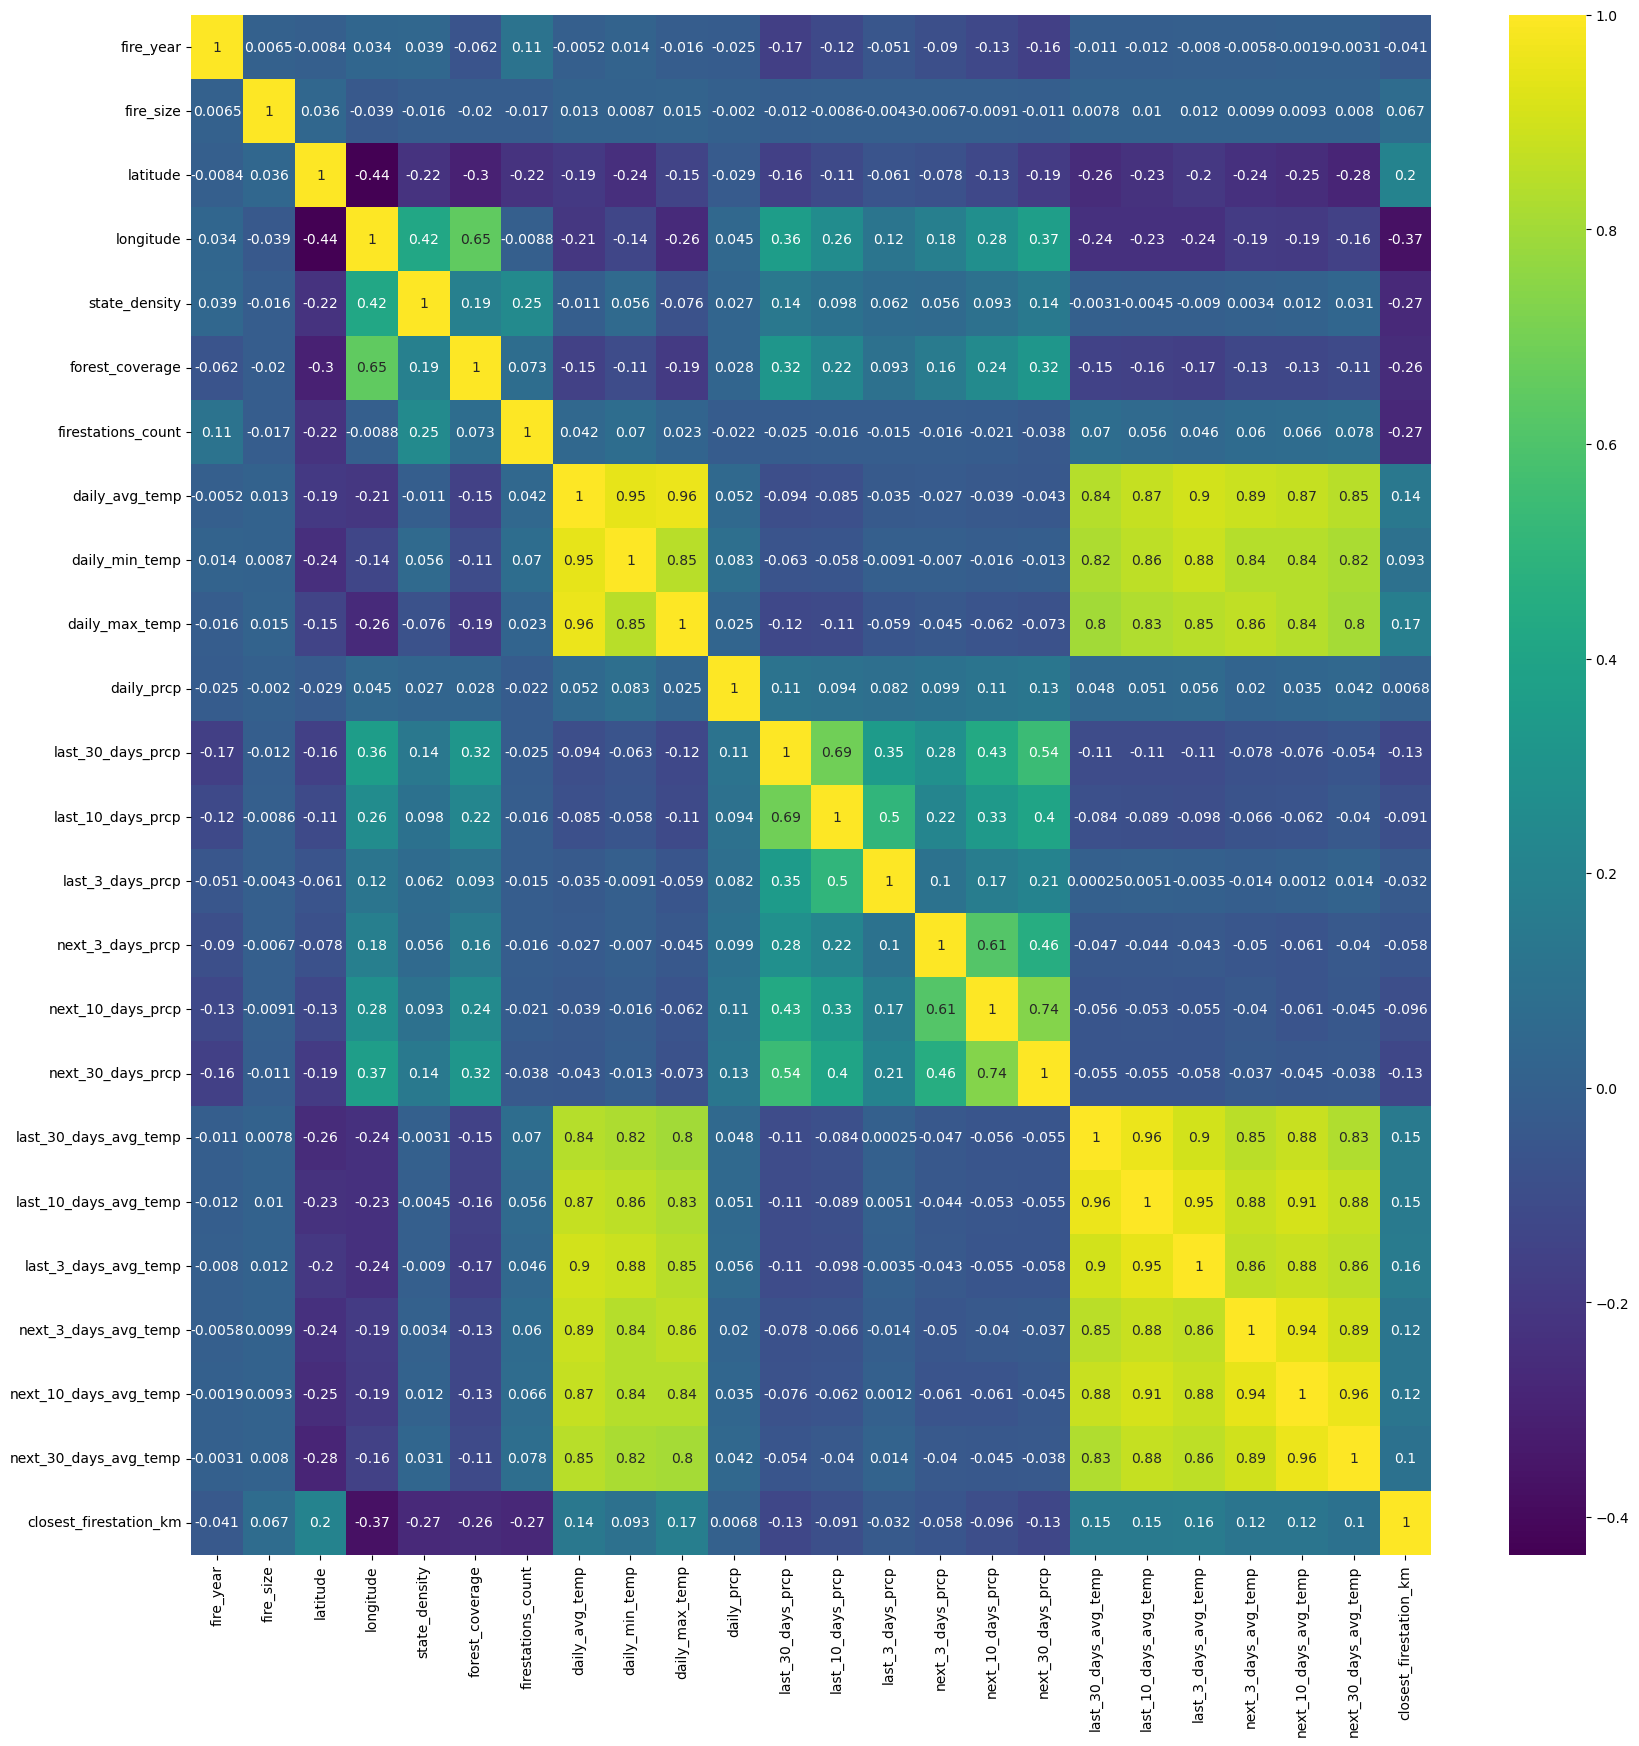

In [22]:
fig= plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap='viridis');

In [6]:
#vérification valeurs nulles
df.isna().any().sum()

0

In [9]:
#Affichage de la distribution par classe
df['fire_size_class'].value_counts(normalize=True)

B    0.502092
A    0.353674
C    0.115304
D    0.015090
E    0.007567
F    0.004243
G    0.002030
Name: fire_size_class, dtype: float64

<AxesSubplot:xlabel='fire_size_class', ylabel='count'>

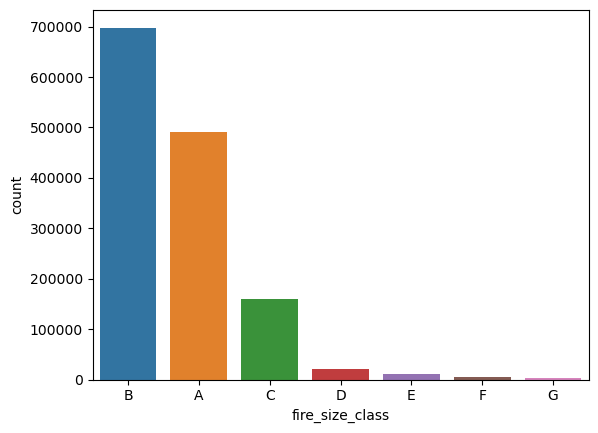

In [9]:
# Graphique de distribution des classes de feux
sns.countplot(df.fire_size_class, order=df.fire_size_class.value_counts().index)

### Transformation des variables catégorielles en variables numériques

In [3]:
# Transformation des coordonnées en variable catégorielle
import pygeohash as pgh
create_geohash = lambda row: pgh.encode(row['latitude'], row['longitude'], 2)
df["geohash"] = df[["latitude", "longitude"]].apply(create_geohash, axis=1)

# Modification de la taille des feux de A à G par 1 à 7 
to_replace = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
replace_with = [1, 2, 3, 4, 5, 6, 7]
df['fire_size_class'] = df['fire_size_class'].replace(to_replace, replace_with)

# MTransformation de la variable "year" en catégoriel
df['fire_year'] = df['fire_year'].astype(str)

# Transformation des variables catégorielles
df_categorical = df.select_dtypes(include=["object"])
df_categorical = pd.get_dummies(df_categorical, dummy_na=False, drop_first=True)

# Fusion avec le df
df = pd.concat([df, df_categorical], axis=1)
df = df.select_dtypes(exclude=["object"])
df = df.drop(columns=['latitude','longitude'])

### Séparation jeu d'entrainement et jeu de test, Normalisation

In [4]:
data = df.drop("fire_size_class", axis = 1)
target = df["fire_size_class"]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 66, stratify = target)

### Normalisation des données

In [5]:
# On normalise nos données :
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## II -  Entraînement de modèles de classification: SGD, RF, DT, XGBoost

### SGD

In [11]:
# Définition des modèles
sgd = SGDClassifier()
# Entraînement du modèle
sgd.fit(X_train_scaled, y_train)
print("test score du sgd : {}".format(sgd.score(X_test_scaled, y_test)))
print("train score du sgd : {}".format(sgd.score(X_train_scaled, y_train)))

# Prédiction du modèle
y_pred = sgd.predict(X_test_scaled)

test score du sgd : 0.5973222184661195
train score du sgd : 0.5966191479720642


In [12]:
# Matrice de correlation
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite      1       2   3   4   5   6   7
Classe réelle                                    
1               65014   33140  50  23  46  62  10
2               38393  100993  66  35  43  69  16
3                5594   26320  45  22  18  42  21
4                1347    2796  17   6   6  15   9
5                 916    1152  13   1   2  14   6
6                 642     489  13   2   1  22  11
7                 420     113   8   0   0  10  13

In [13]:
# Rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.66      0.62     98345
           2       0.61      0.72      0.66    139615
           3       0.21      0.00      0.00     32062
           4       0.07      0.00      0.00      4196
           5       0.02      0.00      0.00      2104
           6       0.09      0.02      0.03      1180
           7       0.15      0.02      0.04       564

    accuracy                           0.60    278066
   macro avg       0.25      0.20      0.19    278066
weighted avg       0.54      0.60      0.55    278066



### RandomForestClassifier

In [14]:
rf = RandomForestClassifier()
# Entraînement du modèle
rf.fit(X_train, y_train)
print("test score du rf : {}".format(rf.score(X_test, y_test)))
print("train score du rf : {}".format(rf.score(X_train, y_train)))

# Prédiction du modèle
y_pred = rf.predict(X_test)

test score du rf : 0.6103479030158308
train score du rf : 0.9961915516460121


In [15]:
# Matrice de correlation
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite      1       2     3    4    5    6   7
Classe réelle                                         
1               62297   34017  1609  187  117   84  34
2               28437  102267  7941  578  231  109  52
3                4058   22489  4817  411  195   56  36
4                 757    2500   648  175   87   22   7
5                 497    1132   267   85   75   35  13
6                 340     574   119   43   32   52  20
7                 215     230    36   16   13   20  34

In [16]:
# Rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.63      0.64     98345
           2       0.63      0.73      0.68    139615
           3       0.31      0.15      0.20     32062
           4       0.12      0.04      0.06      4196
           5       0.10      0.04      0.05      2104
           6       0.14      0.04      0.07      1180
           7       0.17      0.06      0.09       564

    accuracy                           0.61    278066
   macro avg       0.30      0.24      0.26    278066
weighted avg       0.58      0.61      0.59    278066



### DecisionTreeClassifier

In [17]:
dt = DecisionTreeClassifier()
# Entraînement du modèle
dt.fit(X_train, y_train)
print("test score du dt : {}".format(dt.score(X_test, y_test)))
print("train score du dt : {}".format(dt.score(X_train, y_train)))

# Prédiction du modèle
y_pred = dt.predict(X_test)

test score du dt : 0.5317622434961484
train score du dt : 0.9962194227269785


In [18]:
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite      1      2      3     4    5    6    7
Classe réelle                                           
1               56657  34085   5693   894  543  317  156
2               34913  82999  18284  2027  856  393  143
3                5437  17232   7727   971  426  190   79
4                 870   1834    994   259  151   65   23
5                 499    820    412   153  124   65   31
6                 320    435    205    70   61   65   24
7                 164    196     67    34   28   41   34

In [19]:
# Rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.58      0.57     98345
           2       0.60      0.59      0.60    139615
           3       0.23      0.24      0.24     32062
           4       0.06      0.06      0.06      4196
           5       0.06      0.06      0.06      2104
           6       0.06      0.06      0.06      1180
           7       0.07      0.06      0.06       564

    accuracy                           0.53    278066
   macro avg       0.24      0.24      0.24    278066
weighted avg       0.53      0.53      0.53    278066



### XG Boost

In [20]:
#Préparation donnée pour XG Boost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xg = le.fit_transform(y_train) 
y_test_xg = le.fit_transform(y_test) 

#Entrainement du modèle XGBoost
!pip install xgboost
import xgboost as xgb

xg = xgb.XGBClassifier()
xg.fit(X_train_scaled, y_train_xg)
print("test score du xg : {}".format(xg.score(X_test_scaled, y_test_xg)))
print("train score du xg : {}".format(xg.score(X_train_scaled, y_train_xg)))

# Prédiction du modèle
y_pred = xg.predict(X_test_scaled)

# Rapport de classification
print(classification_report(y_test_xg, y_pred))

cm = pd.crosstab(y_test_xg, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

test score du xg : 0.6311055648658952
train score du xg : 0.6366617997166141
              precision    recall  f1-score   support

           0       0.67      0.61      0.64     98345
           1       0.62      0.82      0.70    139615
           2       0.41      0.01      0.03     32062
           3       0.27      0.00      0.00      4196
           4       0.34      0.01      0.02      2104
           5       0.18      0.01      0.01      1180
           6       0.29      0.04      0.07       564

    accuracy                           0.63    278066
   macro avg       0.40      0.22      0.21    278066
weighted avg       0.60      0.63      0.58    278066



Classe prédite      0       1    2   3   4   5   6
Classe réelle                                     
0               60118   38141   75   2   3   3   3
1               24354  114887  330   6   6  12  20
2                3424   28174  425  11  10   7  11
3                 796    3285   92   8   5   4   6
4                 585    1417   67   2  19  10   4
5                 455     663   29   1  11   9  12
6                 302     220   11   0   2   6  23

Les modèles donnant un meilleurs score pour le jeu test sont: XgBoost et RandomForest
Cependant les classes minoritaires des feux de classes importantes sont mal détectés
Nous allons utiliser le module imblearn pour améliorer la détection de classes minoritaires

## III -  Classification pour jeux de données déséquilibrées

Il y a 2 familles de méthodes pour les jeux de données déséquilibrés:
1/ L'oversampling => ici l'algorithme est trop long, pas d'obtention de résultats
2/ L'undersampling => celui-ci a été appliqué avec les algorithmes ayant donné les meilleurs résultats

### XG Boost

In [19]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

#Modification échantillonnage
X_train_ru,y_train_ru= RandomUnderSampler().fit_resample(X_train_scaled,y_train)

#Préparation donnée pour XG Boost
dic_ca= {1:0, 2:1, 3:2, 4:3, 5:4, 6: 5, 7:6}
y_train_xgru= [dic_ca[cat] for cat in y_train_ru]
y_test_xgru= [dic_ca[cat] for cat in y_test] 

#Entrainement du modèle XGBoost
!pip install xgboost
import xgboost as xgb

xgu = xgb.XGBClassifier()
xgu.fit(X_train_ru, y_train_xgru)
print("test score du xgu : {}".format(xgu.score(X_test_scaled, y_test_xgru)))
print("train score du xgu : {}".format(xgu.score(X_train_ru, y_train_xgru)))

# Re-"labellisation" des catégories de 1 à 7
dic_ca_rev= {0:1, 1:2, 2:3, 3:4, 4:5, 5:6,6:7}
y_train_ru= [dic_ca_rev[cat] for cat in y_train_xgru]
y_test_ru= [dic_ca_rev[cat] for cat in y_test_xgru]

# Prédiction du modèle
y_pred = xgu.predict(X_test_scaled)
y_pred= [dic_ca_rev[cat] for cat in y_pred]

# Rapport de classification
print(classification_report(y_test_ru, y_pred))
cm = pd.crosstab(y_test_ru, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

test score du xgu : 0.3913216038206198
train score du xgu : 0.7972258541299528
              precision    recall  f1-score   support

           1       0.61      0.49      0.54    110041
           2       0.64      0.34      0.44    151512
           3       0.22      0.35      0.27     34614
           4       0.03      0.18      0.05      4539
           5       0.02      0.19      0.04      2264
           6       0.02      0.26      0.03      1274
           7       0.02      0.55      0.04       628

    accuracy                           0.39    304872
   macro avg       0.22      0.34      0.20    304872
weighted avg       0.56      0.39      0.45    304872



Classe prédite      1      2      3      4     5     6     7
Classe réelle                                               
1               53772  20319   7406   5350  6071  8480  8643
2               30883  51525  35200  13633  8449  6765  5057
3                3108   8240  12092   4687  3043  2088  1356
4                 453    545    935    809   695   612   490
5                 235    141    253    352   429   461   393
6                 123     39     68    144   197   331   372
7                  51      7      2     29    57   137   345

In [9]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

#Modification échantillonnage
X_ru,y_ru= RandomUnderSampler().fit_resample(X_train_scaled,y_train)

#Entrainement du modèle un algorythme Random Forest Classifier
rfu = RandomForestClassifier()
rfu.fit(X_ru, y_ru)
print("test score du rfu : {}".format(rfu.score(X_test_scaled, y_test)))
print("train score du rfu : {}".format(rfu.score(X_ru, y_ru)))

# Prédiction du modèle
y_pred = rfu.predict(X_test_scaled)

# Rapport de classification
print(classification_report(y_test, y_pred))

test score du rfu : 0.3282853131806135
train score du rfu : 0.9996482795005569
              precision    recall  f1-score   support

           1       0.65      0.48      0.55    116277
           2       0.61      0.22      0.32    150132
           3       0.15      0.32      0.21     30473
           4       0.02      0.20      0.04      4084
           5       0.01      0.15      0.02      2009
           6       0.01      0.26      0.03      1193
           7       0.02      0.57      0.04       704

    accuracy                           0.33    304872
   macro avg       0.21      0.31      0.17    304872
weighted avg       0.56      0.33      0.39    304872



In [10]:
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite      1      2      3      4      5     6     7
Classe réelle                                                
1               55940  16401  10111   7610   8559  9076  8580
2               26513  32630  42042  20318  12152  9712  6765
3                2750   4431   9682   5509   3140  2959  2002
4                 411    300    730    816    628   641   558
5                 230     89    222    347    302   394   425
6                 117     25     65    102    171   316   397
7                  79      5      6     25     61   129   399

Les différentes méthodes d'échantillonnage appliquées sur 2 modèles différents permettent d'améliorer fortement le rappel pour les classes minoritaires 6 et 7, mais pas la précision.
Concrêtement, cela peut être utile pour caractériser des conditions critiques de grands feux et déclencher des alertes préventives.

## GridSearch en combinaison avec Imblearn

In [9]:
!pip install xgboost
import xgboost
!pip install imblearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

#Modification échantillonnage
X_train_ru,y_train_ru= RandomUnderSampler().fit_resample(X_train_scaled,y_train)


#Préparation données pour XG Boost
dic_ca= {1:0, 2:1, 3:2, 4:3, 5:4, 6: 5, 7:6}
y_train_xgru= [dic_ca[cat] for cat in y_train_ru]
y_test_xgru= [dic_ca[cat] for cat in y_test]

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5,10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=4, cv=skf.split(X_train_ru, y_train_xgru), verbose=3, random_state=1001 )

random_search.fit(X_train_ru, y_train_xgru)

print('\n Best hyperparameters:')
print(random_search.best_params_)

  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scikit_learn-1.1.3-cp39-cp39-win_amd64.whl (7.6 MB)
  Attempting uninstall: joblib
    Found existing installation: joblib 0.11
    Uninstalling joblib-0.11:
      Successfully uninstalled joblib-0.11
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[14:10:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 

Passons maintenant à l'entrainement du modèle XGBoost avec les meilleurs hyperparamètres trouvés. 

In [8]:
!pip install xgboost
#!pip install -U imbalanced-learn
import xgboost
from xgboost import XGBClassifier
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

#Modification échantillonnage
X_train_ru,y_train_ru= RandomUnderSampler().fit_resample(X_train_scaled,y_train)
#Préparation donnée pour XG Boost
dic_ca= {1:0, 2:1, 3:2, 4:3, 5:4, 6: 5, 7:6}
y_train_xgru= [dic_ca[cat] for cat in y_train_ru]
y_test_xgru= [dic_ca[cat] for cat in y_test] 

xgb = XGBClassifier(subsample= 0.6, min_child_weight= 1, max_depth= 4, gamma= 5, colsample_bytree= 0.6)
xgb.fit(X_train_ru, y_train_xgru)
print("test score du xgu : {}".format(xgb.score(X_test_scaled, y_test_xgru)))
print("train score du xgu : {}".format(xgb.score(X_train_ru, y_train_xgru)))

# Re-"labellisation" des catégories de 1 à 7
dic_ca_rev= {0:1, 1:2, 2:3, 3:4, 4:5, 5:6,6:7}
y_train_ru= [dic_ca_rev[cat] for cat in y_train_xgru]
y_test_ru= [dic_ca_rev[cat] for cat in y_test_xgru]

# Prédiction du modèle
y_pred = xgb.predict(X_test_scaled)
y_pred= [dic_ca_rev[cat] for cat in y_pred]

# Rapport de classification
print(classification_report(y_test_ru, y_pred))
cm = pd.crosstab(y_test_ru, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

test score du xgu : 0.3931908251997727
train score du xgu : 0.4371124889282551
              precision    recall  f1-score   support

           1       0.60      0.48      0.53     98345
           2       0.65      0.35      0.46    139615
           3       0.22      0.37      0.28     32062
           4       0.04      0.16      0.06      4196
           5       0.02      0.18      0.04      2104
           6       0.01      0.21      0.03      1180
           7       0.02      0.62      0.03       564

    accuracy                           0.39    278066
   macro avg       0.22      0.34      0.20    278066
weighted avg       0.57      0.39      0.45    278066



Classe prédite      1      2      3     4     5     6      7
Classe réelle                                               
1               46919  18491   6930  3046  4648  7743  10568
2               27377  48892  32723  9716  8170  6472   6265
3                2973   7040  11863  3783  2655  1995   1753
4                 426    446    925   688   626   513    572
5                 231    141    245   283   369   372    463
6                 108     44     62    97   197   251    421
7                  49      8      8     8    38   102    351

Le score général a été légèrement augmenté (passant de 0.3913 à 0.3997). Par contre le surapprentissage a été nettement réduit. L'amélioriation majeure est plutôt le rappel de la classe 7: 0.62 pour une valeur initiale de 0.55. Pour rappel, cette donnée a une valeur dans la pratique car elle permet de détecter les conditions critique pour le déclenchement d'un feu de cette catégorie.

## Interprétation du modèle

Le modèle XGBoost est donc le modèle sélectionné dans ce projet.
Cependant, il est considéré par beaucoup comme une 'black box' inexplicable.

Nous allons utiliser le package Shap pour tenter de comprendre comment le modèle a fonctionné et quelles variables ont eu le plus de poids.

In [7]:
!pip install shap

     -------------------------------------- 435.6/435.6 kB 1.0 MB/s eta 0:00:00


In [52]:
import xgboost as xgb

#Conversion des jeux de données en DMatrix
dtrain = xgb.DMatrix(X_train_ru, y_train_ru)
dtest = xgb.DMatrix(X_test_scaled)

# xgboost params
params = {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.6}

# Entrainement du modèle
model = xgb.train(params, dtrain)
pred = model.predict(dtest)

Nous allons créer la matrice des valeurs SHAP pour chaque individu et chaque variable. 
Chaque ligne correspond à la différence entre la sortie du modèle pour un individu et la valeur attendue de la sortie du modèle (l'Expected value). Cette différence nous aidera à expliquer pourquoi le modèle est enclin à prédire le résultat d'une classe spécifique.

In [55]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head(7)

Expected Value: 3.9004164


0         1         2         3         4         5         6    \
0 -0.144127  0.192201 -0.017382  0.052095 -0.000058  0.000196  0.009333   
1 -0.014239  0.124789 -0.062279  0.073118 -0.000058  0.019239  0.003954   
2 -0.100693 -0.722901 -0.186440 -0.012551 -0.000058 -0.026886  0.003954   
3 -0.128771  0.279318 -0.133810  0.070790 -0.000101  0.062717  0.009333   
4 -0.142122  0.270167 -0.053952 -0.144081  0.000289 -0.006038  0.006252   
5 -0.136482  0.208349 -0.071671  0.027908 -0.000058  0.020916  0.002058   
6 -0.088795 -0.806455 -0.188580  0.024723 -0.000058  0.020591  0.009333   

        7         8         9    ...  153  154       155  156  157       158  \
0  0.035910 -0.005607  0.014569  ...  0.0  0.0 -0.001434  0.0  0.0  0.001593   
1 -0.107137 -0.037012  0.014569  ...  0.0  0.0 -0.009720  0.0  0.0  0.008042   
2  0.016265  0.014583  0.012063  ...  0.0  0.0 -0.009720  0.0  0.0  0.002556   
3  0.057583  0.029169  0.012063  ...  0.0  0.0 -0.001434  0.0  0.0  0.001802   
4  0.035910  0.006300  0.012063  ...  0.0  0.0 -0.001434  0.0  0.0  0.001782   
5  0.036278  0.014377  0.012063  ...  0.0  0.0 -0.009720  0.0  0.0  0.001782   
6  0.015897  0.014838  0.012063  ...  0.0  0.0 -0.001434  0.0  0.0  0.002556   

   159  160  161  162  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  
5  0.0  0.0  0.0  0.0  
6  0.0  0.0  0.0  0.0  

[7 rows x 163 columns]

Affichons les features importances obtenues avec SHAP

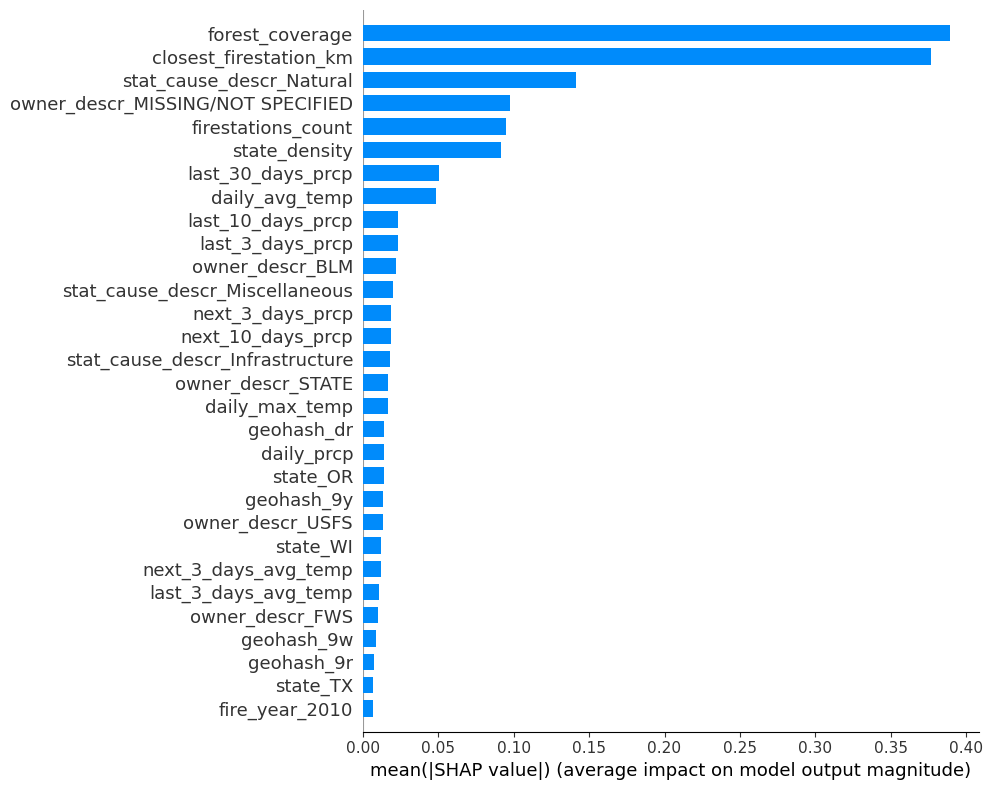

In [62]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,8),max_display=30)

Nous pouvons analyser les dépendances entre variables, par exemple entre la variable de la distance de la caserne de pompiers la plus proche et la cause naturelle.

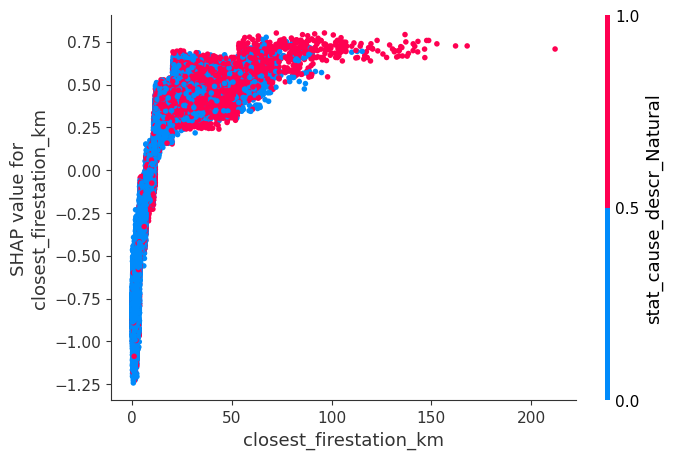

In [69]:
shap.dependence_plot("closest_firestation_km", shap_values, X_test, interaction_index= "stat_cause_descr_Natural")

Il y a ainsi une forte corrélation: plus la caserne de pompier est éloignée plus la cause tend à être naturelle.

In [71]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:])

L'un des principaux avantages du SHAP est qu'il permet de construire des graphiques globaux interactifs qui peuvent visualiser et expliquer plusieurs prédictions à la fois. Ici, nous visualisons les décisions de prédictions du modèle pour les 1000 premiers échantillons de données de test.

In [51]:
shap.force_plot(explainer.expected_value, shap_values[:1000], X_test[:1000])